In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# LIBRARIES

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time

#Separate import for numpy and jax.numpy to have major felxibility
import jax.numpy as jnp
import numpy as np
from jax import jit,lax,random
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
from tensorflow_probability.substrates import jax as jtfp
jtfd = jtfp.distributions

np.random.seed(0)

/Users/leopere/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# LOAD DATA

In [3]:
sampled_perturbed = np.load('sampled_2D_two_clusters.npy')

In [4]:
data = sampled_perturbed[0 : 1000]

In [5]:
#DEFINING NUMBER OF CLUSTERS AND DIMENSION OF DATA
k = 10
d = 2
#Key to store for random generation
rng_key = random.PRNGKey(0)

# GIBBS SAMPLER

In [6]:


def run_one_gibbs(data, cluster_allocs, uniq_vals, weights, alpha, lam , key):
    
    """
    Run one gibbs sampler iteration
    Takes in input values of the previous iteration and sample the new values from sample_uniq_vals_fullcond, update_weights and update_cluster_allocs
    Returns:   
    
    -cluster_allocs: for every data point, the cluster assigned
    -uniq_vals: array of parameters of the distributions. Matrix has d rows of the type:[mu[0], var[0,0], var[0,1]]
    -weights: array with the weights of the clusters 
     """
    
    n_clus = len(weights)
    
    for h in range(n_clus):
        
        #Extract data assigned to cluster h and sample 
        clusdata = data[cluster_allocs == h]
        if len(clusdata) != 0:
            uniq_vals[h, :],key = sample_uniq_vals_fullcond(clusdata,lam,key)
        else:
            uniq_vals[h, :],key = sample_uniq_vals_prior(lam,key)
    
    #I pass weights to make sure i can compute n_clus (otherwise JAX gives problem with for loop)
    weights,key = update_weights(cluster_allocs ,alpha,weights,key)
    
    cluster_allocs,key = update_cluster_allocs(data, weights, uniq_vals,key)
    
    return cluster_allocs, uniq_vals, weights, key




def run_mcmc(data, k,  key , niter=2500, nburn=500, thin=5 ): 
    
    """
    Runs entire MCMC
    Takes in input data, number of clusters, number of iterations, burn-in and thin
    Returns the parameters recorded after burn-in phase
    """
    
    b = time.time() # only to measure time
    
    
    #Priors
    cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
    weights = np.ones(k)/k
    alpha = 0.1
    lam = 0.1
    uniq_vals = np.dstack([
        tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k),
        tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
    
    #Output values
    allocs_out = []
    uniq_vals_out = []
    weights_out = []
    
    #Useful value
    data_mean = jnp.mean(data, axis = 0)
    
    #Iterations
    for i in range(niter):
        cluster_allocs, uniq_vals, weights , key = run_one_gibbs(
            data, cluster_allocs, uniq_vals, weights, alpha, lam , key)
        
        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            uniq_vals_out.append(uniq_vals.copy())
            weights_out.append(weights)
            
        if i % 10 == 0:
            a = time.time()
            print("\rIter {0} / {1}".format(i+1, niter) + " Remaining minutes: " + str(round((a-b)*(niter-i)/(60*10) ,1)) , flush=False, end=" ")
            b = time.time()
            
    return allocs_out, uniq_vals_out, weights_out,key

In [10]:
#JAX implemented full conditionals
@jit
def update_cluster_allocs(data, weights, uniq_vals, key):
    
    key, subk = random.split(key)
    
    #Evaluate Multivariate Normal density with means and covariances coming from the uniq_vals
    logprobs = jtfd.MultivariateNormalFullCovariance(uniq_vals[:,:,0], uniq_vals[:,:,1:3]).log_prob(data[:, np.newaxis])
    logprobs += jnp.log(weights)
    probs =  jnp.exp(logprobs)/jnp.sum(jnp.exp(logprobs), axis=1)[:,None]

    return jtfd.Categorical(probs=probs, validate_args=True).sample(seed = subk),key

@jit
def update_weights(cluster_allocs, alpha,weights,key):

    key, subk = random.split(key)
    n_clus = len(weights)
    n_by_clus = jnp.array([jnp.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = jnp.ones(k) * alpha + n_by_clus
    return jtfd.Dirichlet(post_params.astype(float)).sample(seed = subk),key


#The idea should be to always pass fixed size arguments, otherwise the function has to be compiled every time
#In this case, it seems to me that all shapes are fixed, the only issue was with sample_uniq_vals_fullcond 
#where clusdata changes size, so i used an auxiliary function which receives preprocessed values of fixed size


def sample_uniq_vals_fullcond(clusdata, lam , key):
    
    n=len(clusdata)
    W0 = jnp.diag(np.ones(d))
    C = (n-1)*jnp.cov(clusdata, rowvar = False)
    clus_mean = jnp.mean(clusdata, axis = 0)

    return sample_uniq_vals_fullcond_auxiliary(clus_mean,lam,W0,C,n,key)

@jit
def sample_uniq_vals_fullcond_auxiliary(clus_mean,lam,W0,C,n,key):
    
    key , subk1 , subk2 = random.split(key,3)
    
    data_mean = jnp.mean(data, axis = 0)
    D = lam*n / (lam+n) * jnp.dot(clus_mean-data_mean,clus_mean-data_mean)
    W = jnp.linalg.inv(W0 + C + D)
    chol = jnp.linalg.cholesky(W) 
    
    prec = jtfd.WishartTriL(df=(d+n).astype(float), scale_tril=chol).sample(seed = subk1)
    var = jnp.linalg.inv(prec)
    posterior_mean = (lam * data_mean + n*clus_mean)/(lam+n)
    posterior_covariance = var/(lam+n)
    mu = jtfd.MultivariateNormalFullCovariance(posterior_mean, posterior_covariance).sample(seed = subk2)
    
    return jnp.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]]),key


@jit
def sample_uniq_vals_prior(lam,key):
    
    #In case the cluster is empty, we sample from priors
    key,subk1,subk2 = random.split(key,3)
    chol = jnp.linalg.cholesky(jnp.diag(jnp.ones(d))) 
    prec = jtfd.WishartTriL(df=d, scale_tril=chol).sample(seed = subk1)
    var = jnp.linalg.inv(prec)
    data_mean = jnp.mean(jnp.array(data), axis = 0)
    mu = jtfd.MultivariateNormalFullCovariance(data_mean, var/lam).sample(seed = subk2)
    return jnp.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]]),key
    




In [11]:
# FUNCTION TO UPDATE THE CLUSTER ALLOCATIONS
# IT EVALUATE THE MIXTURE ON THE DATA AND COMPUTE THE NEW PROBABILITIES FOR EACH CLUSTER AND RETURN THE NEW ALLOCATIONS

def update_cluster_allocs_slow(data, weights, uniq_vals):
    
    logprobs = tfd.MultivariateNormalFullCovariance(uniq_vals[:,:,0], uniq_vals[:,:,1:3]).log_prob(data[:, np.newaxis])
    logprobs += np.log(weights)
    probs =  np.exp(logprobs)/np.sum(np.exp(logprobs), axis=1)[:,None]

    return tfd.Categorical(probs=probs, validate_args=True).sample()


# FUNCTION TO UPDATE THE WEIGHTS 
# IT UPDATES THE PARAMETERS OF THE DIRICHLET AND RETURNS THE NEW WEIGHTS
def update_weights_slow(cluster_allocs, n_clus, k, alpha):

    n_by_clus = np.array([np.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = np.ones(k) * alpha + n_by_clus
    return tfd.Dirichlet(post_params.astype(float)).sample()


# FUNCTIONS TO SAMPLE FROM THE PRIORS AND FROM THE FULL CONDITIONALS
# THEY BOTH USE THE CHOLESKY FACTORIZATION FOR THE NEW COVARIANCE MATRIX AND THEN SAMPLE FROM A WISHART(COV MATRIX) AND MULTIVARIATE NORMAL(MEAN)
# RETURN AN ARRAY OF ARRAYS
def sample_uniq_vals_prior_slow(lam):
    
    chol = tf.linalg.cholesky(np.diag(np.ones(d))) 
    prec = tfd.WishartTriL(df=d, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis = 0), var/lam).sample()
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])
    

def sample_uniq_vals_fullcond_slow(clusdata, lam):
    
    n=len(clusdata)
    W0 = np.diag(np.ones(d))
    C = (n-1)*np.cov(clusdata, rowvar = False)
    D = lam*n/(lam+n)*np.dot(np.mean(clusdata, axis = 0)-np.mean(data, axis = 0),np.mean(clusdata, axis = 0)-np.mean(data, axis = 0))
    W = tf.linalg.inv(W0 + C + D)
    chol = tf.linalg.cholesky(W) 
    prec = tfd.WishartTriL(df=d+n, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance((lam * np.mean(np.array(data), axis = 0)+n*np.mean(clusdata, axis = 0))/(lam+n), var/(lam+n)).sample()
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])


In [12]:
#RUNNING THE MCMC
start = time.time()
allocs_out, uniq_vals_out, weights_out,key = run_mcmc(data, k , rng_key)
end = time.time()
print("Total time: " + str(end-start))

#Around 1 minutes instead of 15, 15x speedup :) 

skip assert _assert_compare_to_zero
skip assert _assert_near
Iter 2491 / 2500 Remaining minutes: 0.0 Total time: 77.77299189567566


# Single functions Speed Comparison

In [ ]:
#Data to use for comparison
cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
weights = np.ones(k)/k
alpha = 0.1
lam = 0.1
clusdata = data[cluster_allocs == 2]
uniq_vals = np.dstack([
    tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k),
    tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
key = rng_key
n_clus = 10

%timeit sample_uniq_vals_fullcond(clusdata,lam,key)
%timeit sample_uniq_vals_fullcond_slow(clusdata,lam)
%timeit update_weights(cluster_allocs, alpha,weights,key)
%timeit update_weights_slow(cluster_allocs, n_clus, k, alpha)
%timeit update_cluster_allocs(data, weights, uniq_vals,key)
%timeit update_cluster_allocs_slow(data, weights, uniq_vals)
%timeit sample_uniq_vals_prior(lam,key)
%timeit sample_uniq_vals_prior_slow(lam)

# PLOT OF THE CLUSTERS

2    504
6    496
dtype: int64


<BarContainer object of 2 artists>

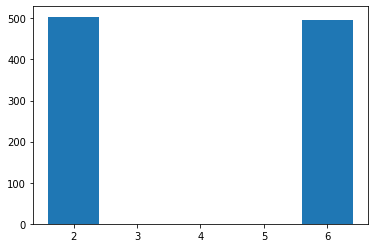

In [13]:
#View the number of points inside each cluster at the final iteration
print(pd.Series(allocs_out[-1]).value_counts())

x, y = np.unique(allocs_out[-1], return_counts=True)


plt.bar(x, y)


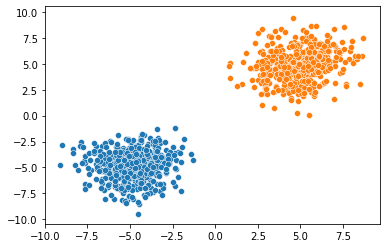

In [14]:
#scatterplot of clusters from last iteration
for h in range(k):
    currd = data[allocs_out[-1] == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd])

ValueError: The palette list has the wrong number of colors.

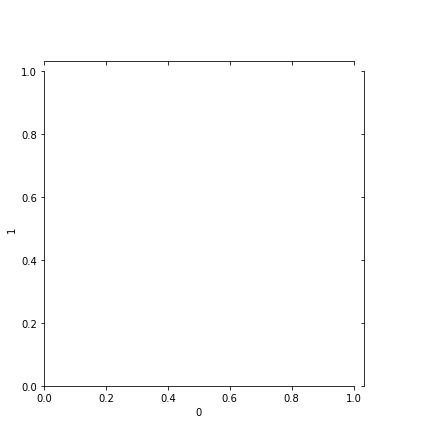

In [15]:
#scatterplot of clusters with marginal distributions
data1=pd.DataFrame(data)
data1["allocs"]=allocs_out[-1]
sns.jointplot(data=data1,x=data1[0],y=data1[1], hue="allocs",palette=sns.color_palette("hls", 4))

In [16]:
#MEDIE NEI CLUSTER DELL'ULTIMA ITERAZIONE
M = [[np.mean(data[allocs_out[-1] == h][:,0]), np.mean(data[allocs_out[-1] == h][:,1])] for h in [5,8,9]]
M=pd.DataFrame(M)


/Users/leopere/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/leopere/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# TRACE PLOTS

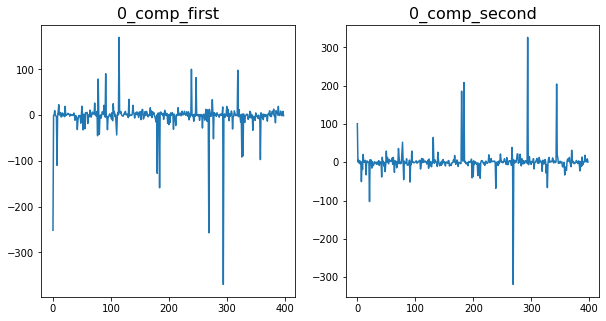

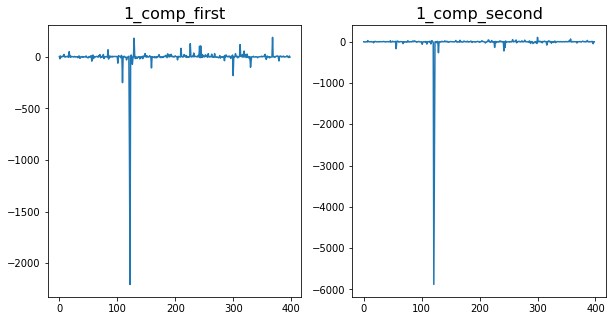

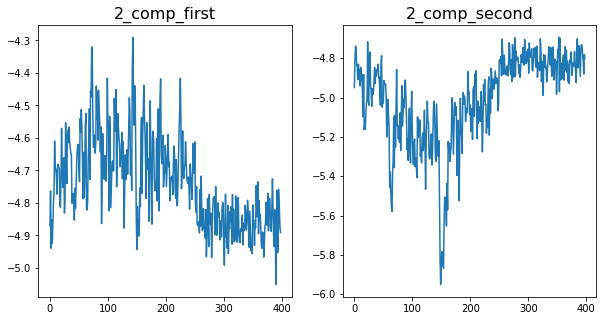

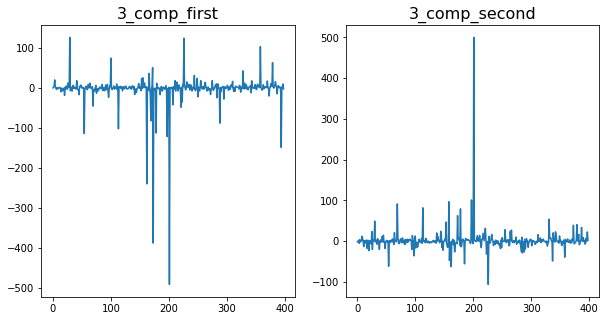

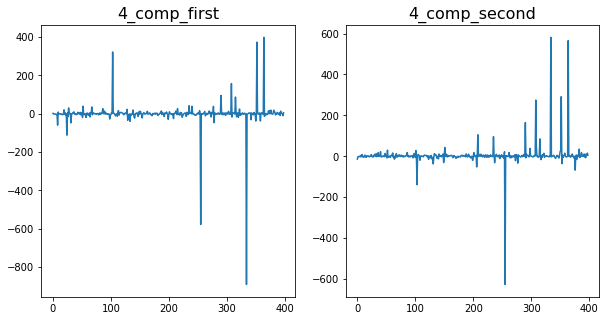

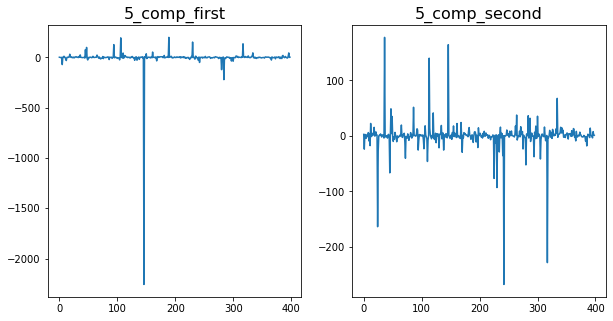

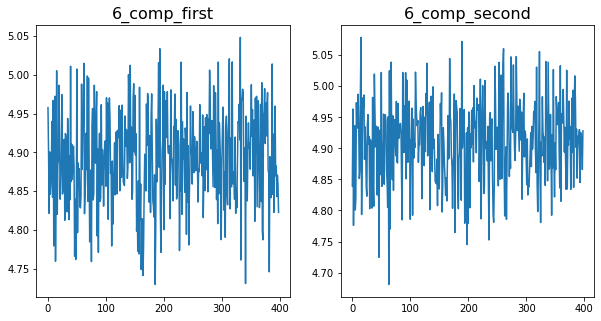

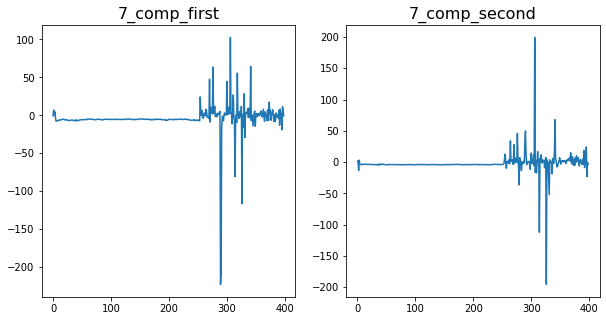

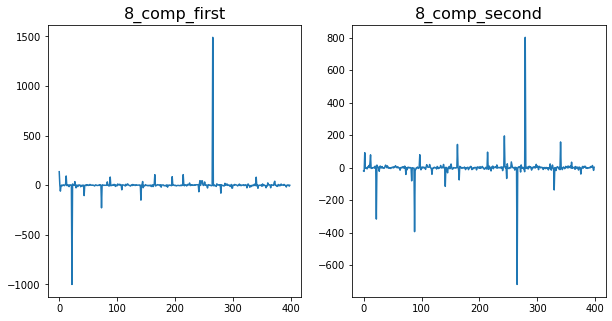

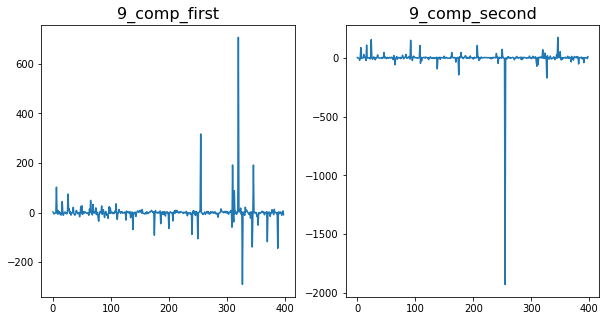

In [17]:
means = [val[:,:,0] for val in uniq_vals_out]
for i in range(len(weights_out[0])):
    

    #Get mean of i-th gaussian component
    first_comp = [mean[i,:] for mean in means]

    #Get mu_1 and mu_2 from the i-th component (multivariate) mean
    first_comp_first = [first_comp_mean[0] for first_comp_mean in first_comp]
    first_comp_second = [first_comp_mean[1] for first_comp_mean in first_comp]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp_first)), first_comp_first)
    axes[0].set_title(str(i) + "_comp_first", fontsize=16)

    axes[1].plot(np.arange(len(first_comp_second)), first_comp_second,)
    axes[1].set_title(str(i) + "_comp_second", fontsize=16)

    plt.show()

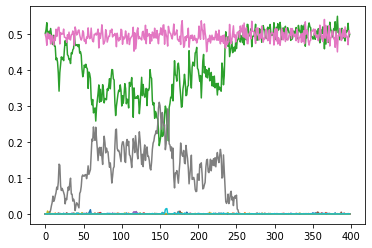

In [21]:
#Weights plot
fig,ax = plt.subplots(1)
for i in range(k):
    ax.plot(np.arange(len(weights_out)), [weight[i] for weight in weights_out])
    
plt.show()

# BEST CLUSTER

In [ ]:
#Find best clustering obtained during the MCMC using the Binder Loss 

def get_psm(clus_alloc_chain):
    """
    Returns the posterior similarity matrix, i.e.
        out[i, j] = P(c_i == c_j | all the rest)
    for each pair of observations
    """
    #Fare confronto tra colonna i e j della matrice e poi calcolare da li
    c_chain = np.vstack(clus_alloc_chain)
    out = np.zeros((c_chain.shape[1], c_chain.shape[1]))
    for i in range(c_chain.shape[1]):
        for j in range(c_chain.shape[1]):
            out[i,j] = np.sum(c_chain[:,i] == c_chain[:,j]) / c_chain.shape[0]
            
    return out


def minbinder_sample(clus_alloc_chain, psm):
    """
    Finds the iteration for which the Binder loss is minimized
    and returns the associated clustering
    """
    losses = np.zeros(len(clus_alloc_chain))
    c_chain = np.vstack(clus_alloc_chain)
    
    # You can either cycle through the iterations, or 
    # cycle through the entries in the PSM [i, j]
    # and vectorize the same operation for each iteration!
    
    mat = np.zeros( ( c_chain.shape[0], c_chain.shape[1]**2 ) )
    k = 0
    for i in range(c_chain.shape[1]):
        for j in range(c_chain.shape[1]):
            mat[:,k] = ( (c_chain[:,i] == c_chain[:,j]).astype(int) - psm[i,j] * np.ones(c_chain.shape[0]) ) **2
            k = k+1
    
    losses = np.sum(mat, axis = 1)
    
    best_iter = np.argmin(losses)
    return clus_alloc_chain[best_iter]



def unique_vals_given_clus(unique_vals_chain, clus_alloc_chain, best_clus,n_clus):
    #Finds the unique values associated to the best clusters obtained during MCMC
    
    c_allocs = np.stack(clus_alloc_chain)
    uniq_vals = np.stack(unique_vals_chain)
    means = uniq_vals[:, :, : , 0]
    variances = uniq_vals[:, :, : , 1:3]
    out1 = []
    out2 = []
    for h in range(n_clus):
        data_idx = np.where(best_clus == h)[0]
        uniq_vals_idx = c_allocs[:, data_idx] # -> Matrix [n_iter x n_data_in_clus]
        means_by_iter = np.empty((c_allocs.shape[0], len(data_idx),2))
        vars_by_iter = np.empty((c_allocs.shape[0], len(data_idx),2,2))
        for i in range(c_allocs.shape[0]):
            means_by_iter[i, :] = means[i,uniq_vals_idx[i,:],:]
            vars_by_iter[i, :] = variances[i,uniq_vals_idx[i,:]]

        avg_mean_by_iter = np.mean(means_by_iter , axis = 1)
        avg_var_by_iter = np.mean(vars_by_iter , axis = 1)
        
        muhat = np.mean(avg_mean_by_iter,axis=0)
        sigsqhat = np.mean(avg_var_by_iter,axis=0)
        out1.append(np.array(muhat))
        out2.append(np.array(sigsqhat))
    
    #If there are no points in certain clusters, the output would be full of NANs for the cluster. This gives problems
    #I replace the NANs with some 0
    for i in range(len(out1)):
        if(np.any(np.isnan(out1[i]))):
            out1[i] = np.zeros(shape = out1[i].shape)
        if(np.any(np.isnan(out2[i]))):
            out2[i] = np.eye(N = out2[i].shape[0])
    
        
    return out1,out2


psm = get_psm(allocs_out)
best_clus = minbinder_sample(allocs_out,psm)

mu_lis,var_lis = unique_vals_given_clus(uniq_vals_out, allocs_out, best_clus,k)
weights = np.sum(best_clus == np.arange(k)[:, np.newaxis], axis=1) / len(data)



In [ ]:
#Plot resulting density of the mixture

def eval_multivariate_mixture_dens(locations, variances, weights, xgrid):
    eval_comps = tfd.MultivariateNormalFullCovariance(locations, np.sqrt(variances)).prob(xgrid[:, np.newaxis])
    return np.sum(eval_comps * weights, axis=1)

grid_1D = np.linspace(-10, 10, 100)
grid_2D = np.array([[x0, y0] for x0 in grid_1D for y0 in grid_1D])
X,Y = np.meshgrid(grid_1D,grid_1D) 
fig = plt.figure()
ax = plt.axes()
ax.contour(X, Y,np.reshape(eval_multivariate_mixture_dens(mu_lis, var_lis, weights, grid_2D), newshape = X.shape) , 50, cmap='viridis')
ax.set_title('Best Clustering');
for h in range(k):
    currd = data[best_clus == h]
    ax.scatter(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd],)